In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Constants
k_values = [16, 64, 256]  # Different numbers of hash functions

# Range of J(A, B) values from 0 to 1
j_values = np.linspace(0, 1, 100)

# Plotting setup
plt.figure(figsize=(10, 6))

# Calculate and plot P(X >= m) for each J(A, B) and each k
for k in k_values:
    m = k // 2  # Set m as half of k
    probabilities = [1 - binom.cdf(m-1, k, j) for j in j_values]
    # Save to file
    with open(f'data_k{k}_m{m}.dat', 'w') as f:
        for j, p in zip(j_values, probabilities):
            f.write(f"{j} {p}\n")
    # plt.plot(j_values, probabilities, label=f'P(X ≥ {m}) with k = {k}')

# plt.title('Probability P(X ≥ m) as a Function of J(A, B) for Various k and m')
# plt.xlabel('J(A, B) - True Jaccard Similarity')
# plt.ylabel('Probability P(X ≥ m)')
# plt.grid(True)
# plt.legend()
# plt.show()



<Figure size 1000x600 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, binom
import hashlib

def simulate_sets(jaccard_sim, total_elements=1000):
    # Calculate the size of the intersection between A and B
    intersection_size = int(jaccard_sim * total_elements)
    
    # Create the intersection set with the calculated size
    intersection_set = set(np.random.choice(range(64 * total_elements), size=intersection_size, replace=False))
    
    # Calculate the size of the unique parts of A and B, with half for each
    total_unique_elements = total_elements - intersection_size
    unique_elements_count_a = total_unique_elements // 2
    unique_elements_count_b = total_unique_elements // 2 + total_unique_elements % 2  # Add one more if odd
    
    # Expand set A with unique elements not in the intersection
    unique_a_elements = set(np.random.choice(range(64 * total_elements), size=unique_elements_count_a, replace=False))
    # Exclude any that are already in the intersection set
    unique_a_elements -= intersection_set
    
    # Repeat for set B, ensuring unique elements do not appear in set A
    unique_b_elements = set(np.random.choice(range(64 * total_elements), size=unique_elements_count_b, replace=False))
    # Exclude any that are already in the intersection set or in unique A
    unique_b_elements -= (intersection_set | unique_a_elements)
    
    # Combine the intersection with the unique parts to form A and B
    set_a = intersection_set | unique_a_elements
    set_b = intersection_set | unique_b_elements
    
    return set_a, set_b


def hash_elements(set_elements, k):
    hash_space = 2**20  # Define a large hash space
    bin_edges = np.linspace(0, hash_space, k+1)
    hash_func = lambda x: int(hashlib.sha256(str(x).encode()).hexdigest(), 16) % hash_space
    hashed_elements = np.array([hash_func(el) for el in set_elements])
    min_hashes = [min(hashed_elements[(hashed_elements >= bin_edges[i]) & (hashed_elements < bin_edges[i+1])], default=np.inf) for i in range(k)]
    return min_hashes

def estimate_jaccard(set_a, set_b, k):
    hashes_a = hash_elements(set_a, k)
    hashes_b = hash_elements(set_b, k)
    N_mat = sum(1 for i in range(k) if hashes_a[i] == hashes_b[i] and hashes_a[i] != np.inf)
    N_emp = sum(1 for i in range(k) if hashes_a[i] == np.inf and hashes_b[i] == np.inf)
    if k - N_emp == 0:
        return 0  # Avoid division by zero
    return N_mat / (k - N_emp)

# Parameters
k = 64
j_values = np.linspace(0, 1, 100)  # For better resolution, adjust number of points
simulations_per_point = 100  # Number of simulationss per Jaccard index value
results = []

for j in j_values:
    count_ge_05 = 0
    for _ in range(simulations_per_point):
        a, b = simulate_sets(j)
        estimated_j = estimate_jaccard(a, b, k)
        if estimated_j >= 0.5:
            count_ge_05 += 1
    probability_ge_05 = count_ge_05 / simulations_per_point
    results.append(probability_ge_05)

# smooth the results
from scipy.signal import savgol_filter
smoothed_sg = savgol_filter(results, 11, 3)  # window size 11, polynomial order 3



In [14]:
with open(f'oph_k64.dat', 'w') as f:
        for j, p in zip(j_values, smoothed_sg):
            f.write(f"{j} {p}\n")

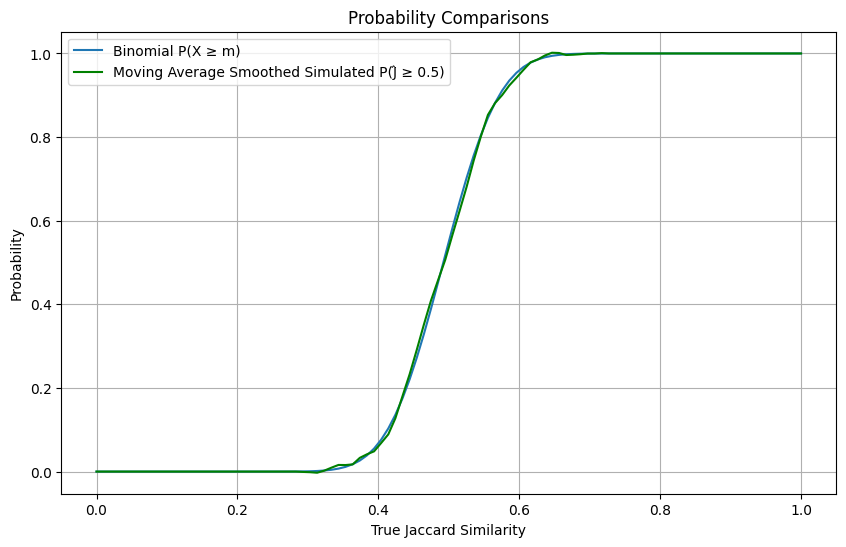

In [9]:


# Plotting both on the same figure
plt.figure(figsize=(10, 6))
plt.plot(j_values, probabilities, label='Binomial P(X ≥ m)')
# plt.plot(j_values, smoothed_results, marker='o', linestyle='-', label='Simulated P(Ĵ ≥ 0.5)')  # results
plt.plot(j_values, smoothed_sg, linestyle='-', color='green', label='Moving Average Smoothed Simulated P(Ĵ ≥ 0.5)')
plt.title('Probability Comparisons')
plt.xlabel('True Jaccard Similarity')
plt.ylabel('Probability')
plt.grid(True)
plt.legend()
plt.show()